# 추석 교통 소요시간 예측

- 사용 데이터
    - 한국도로공사 고속도로 공공데이터 포털, 영업소간 통행시간
        - 2013년 2월 ~ 2022년 2월 데이터 중 추석, 설날 연휴 첫째 날 데이터
    - 공휴일 수 데이터
        - 공휴일의 경우 주말을 포함한 연휴, 징검다리 연휴의 경우 연휴일에 포함
    - 날씨 데이터, 기상청 날씨 누리 일별 날씨 자료
    

### 1. 데이터 준비

In [1]:
import pandas as pd

In [2]:
# 데이터 병합을 위해 첫번째 데이터 불러오기
data = pd.read_csv('20220129.csv')

# 데이터 확인
data.head()

,집계일자,집계시,출발영업소코드,도착영업소코드,TCS차종구분코드,통행시간,Unnamed: 6
0,20220129,21,0,101,1,-1,NaN
1,20220129,16,0,101,3,-1,NaN
2,20220129,16,0,101,1,-1,NaN
3,20220129,21,0,101,3,-1,NaN
4,20220129,13,0,101,1,-1,NaN


In [3]:
# 불필요한 컬럼 제거
del_cols = ['TCS차종구분코드','Unnamed: 6']
data.drop(del_cols, axis = 1, inplace = True)


- 2020년부터 2022년까지는 동일한 데이터 포맷을 사용
- 2012년~2019년 데이터는 컬럼명이 없고 데이터가 '|'로 구분 

In [4]:
csv_list = ['20210918.csv','20210211.csv','20200930.csv','20200124.csv']
for i in csv_list:
    data_temp = pd.read_csv(i)
    del_cols = ['TCS차종구분코드','Unnamed: 6']
    data_temp.drop(del_cols, axis = 1, inplace = True)
    data = pd.concat([data, data_temp])

In [5]:
csv_list = ['20190912.csv','20190202.csv','20180922.csv','20180215.csv',
            '20171003.csv','20170127.csv','20160914.csv','20160206.csv',
            '20150926.csv','20150218.csv','20140906.csv','20140130.csv',
            '20130918.csv','20130209.csv']

for i in csv_list:
    data_temp = pd.read_csv(i,sep='|', header = None)
    del_cols = [4,6]
    data_temp.drop(del_cols, axis = 1, inplace = True)
    data_temp.columns = list(data)
    data = pd.concat([data, data_temp])

In [6]:
data.tail()

,집계일자,집계시,출발영업소코드,도착영업소코드,통행시간
546237,20130209,2,255,254,350
546238,20130209,6,641,560,12444
546239,20130209,3,244,147,1224
546240,20130209,3,135,522,8415
546241,20130209,20,153,275,6895


### 2. 데이터 전처리

In [7]:
data = data.loc[(data['출발영업소코드']==101) & (data['도착영업소코드']==140)]
data = data.loc[(data['통행시간'] != -1)]

In [8]:
import time
from datetime import timedelta
import datetime

def seconds_to_datetime(seconds, format='%H:%M:%S'):
    td = timedelta(seconds=seconds)
    time_obj = time.gmtime(td.total_seconds())
    return time.strftime(format, time_obj)

def hours_to_datetime(hours, format='%H:%M:%S'):
    td = timedelta(hours=hours)
    time_obj = time.gmtime(td.total_seconds())
    return time.strftime(format, time_obj)

def timedelta_to_datetime(td, format='%H:%M:%S'):
    time_obj = time.gmtime(td.total_seconds())
    return time.strftime(format, time_obj)

In [9]:
data['통행시간'] = data['통행시간'].apply(lambda _ : seconds_to_datetime(_))
data['통행시간'] = data['통행시간'].apply(lambda _ : datetime.datetime.strptime( _, '%H:%M:%S'))

data['집계시'] = data['집계시'].apply(lambda _: hours_to_datetime(_))
data['집계시'] = data['집계시'].apply(lambda _ :  datetime.datetime.strptime(_, '%H:%M:%S'))

data['출발시간'] = data['집계시'] - data['통행시간']
data['출발시간'] = data['출발시간'].apply(lambda _ : timedelta_to_datetime(_))
data['출발시간'] = data['출발시간'].apply(lambda _ :  datetime.datetime.strptime(_, '%H:%M:%S'))

data['출발시'] = data['출발시간'].dt.hour
data['출발시'] = data['출발시'].apply(lambda _: hours_to_datetime(_))
data['출발시'] = data['출발시'].apply(lambda _ :  datetime.datetime.strptime(_, '%H:%M:%S'))

data['통행시간'] = data['통행시간'].apply(lambda x: x.strftime('%H:%M:%S'))
data['출발시'] = data['출발시'].apply(lambda x: x.strftime('%H:%M:%S'))


In [10]:
del_cols = ['집계시', '출발영업소코드','도착영업소코드','출발시간']
data.drop(del_cols, axis = 1, inplace =True)

data = data[['집계일자','출발시','통행시간']]

data = data.loc[data['출발시'] == '12:00:00']

index1 = data[data['통행시간'] == '00:00:00'].index
data.drop(index1, inplace = True)

data.reset_index(drop = True, inplace = True)

In [11]:
data['통행시간'] = pd.to_timedelta(data['통행시간'])
data['통행시간_초'] = data['통행시간'].dt.total_seconds()

In [12]:
data['통행시간_초'] = data['통행시간_초'].astype(int)
data = data.groupby(by = '집계일자', as_index = False)['통행시간_초'].mean()


In [13]:
data['통행시간_초'] = data['통행시간_초'].astype(int)
data['집계일자'] = data['집계일자'].astype(str)

In [14]:
# 설날 추석
holiday_type = [0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0]
holiday_type = pd.DataFrame(holiday_type)
data['설날_추석'] = holiday_type

In [15]:
holiday = [3,5,4,4,5,3,4,5,3,3,4,4,5,5,4,5,4,5,5]

holiday = pd.DataFrame(holiday)
data['공휴일수'] = holiday

In [16]:
# 없음 0 연무 1 비 2
weather = [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0]

weather = pd.DataFrame(weather)
data['날씨'] = weather

In [17]:
data = data.loc[data['설날_추석'] == 1]

In [18]:
new_year = [20783,24272,25564,22261,22396,27489,18358,22559,20953]
new_year = pd.DataFrame(new_year)
data.reset_index(drop = True, inplace = True)
data['new_year'] = new_year

[]

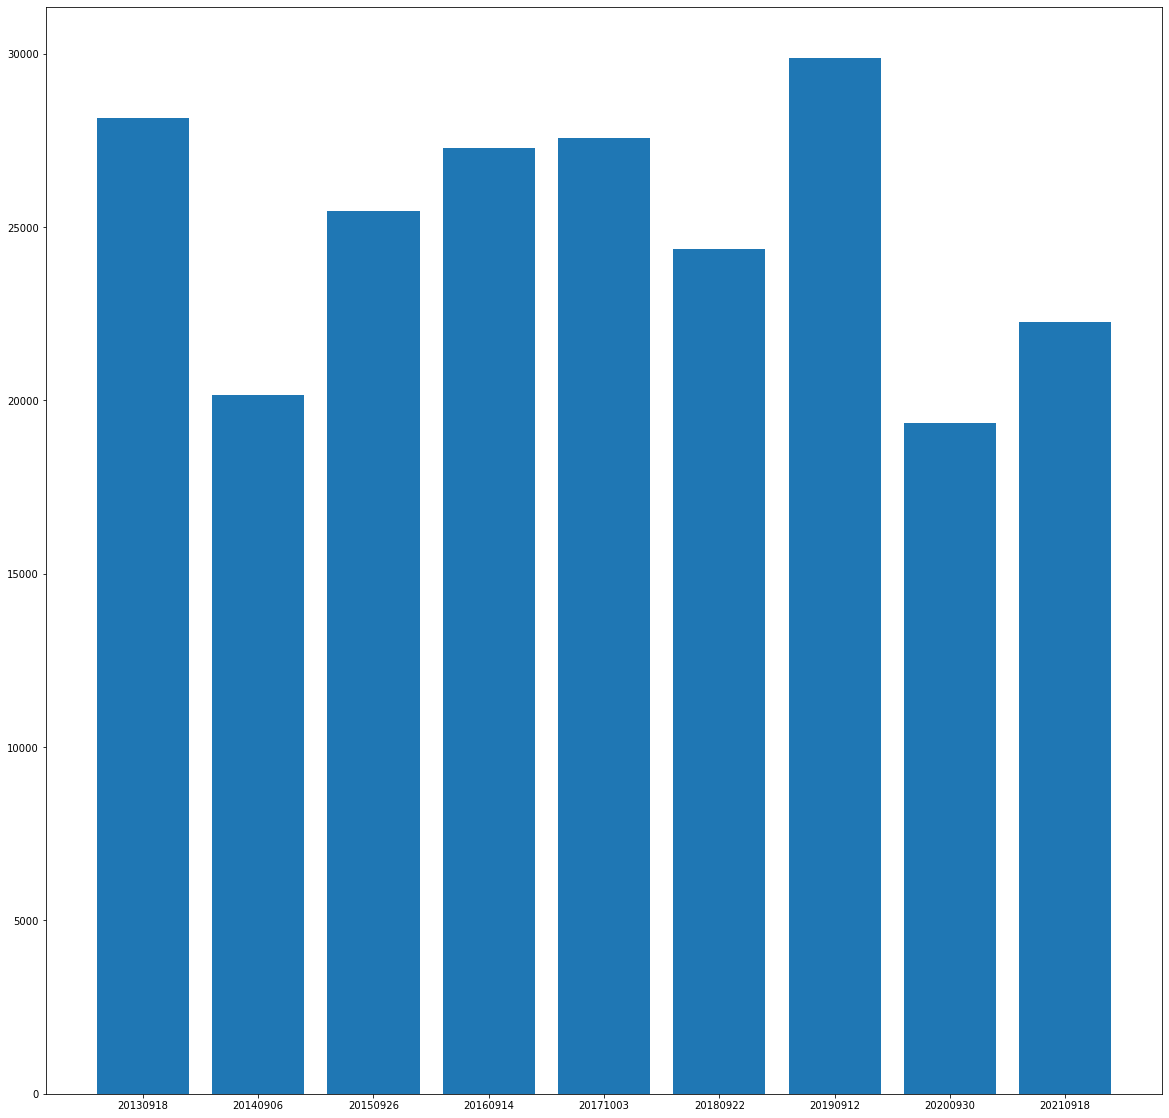

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,20))
plt.bar(x = data['집계일자'],height = data['통행시간_초'])
plt.plot()

In [20]:
import scipy.stats as spst
spst.pearsonr(data['new_year'], data['통행시간_초'])

(-0.4062491965189492, 0.27793359185383804)

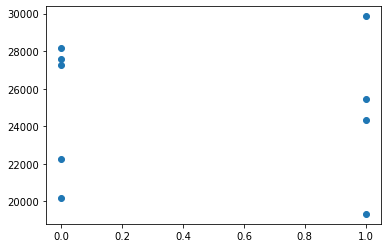

In [21]:
plt.scatter('날씨', '통행시간_초', data = data)
plt.show()

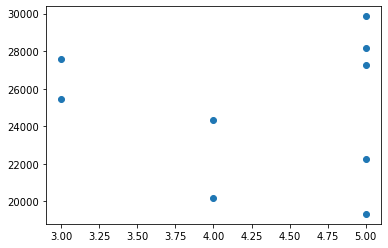

In [22]:
plt.scatter('공휴일수', '통행시간_초', data = data)
plt.show()

모델 학습

In [23]:
# 날씨 데이터는 모델 성능을 저하시켜 제외

data = data[['공휴일수','new_year','통행시간_초']]

In [25]:
target = '통행시간_초'

x = data.drop(target, axis = 1)
y = data.loc[:,target]

In [26]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

In [71]:
model1 = LinearRegression()

In [72]:
model1.fit(x_train, y_train)

LinearRegression()

In [73]:
y_pred = model1.predict(x_test)

In [74]:
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))


MAE: 12831.141138021581
R2: -16.643677650158583


In [75]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor()

In [76]:
xgb_model.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [77]:
y_pred = xgb_model.predict(x_test)

In [78]:
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))

MAE: 1861.3352864583333
R2: 0.3526658863323715


In [79]:
from sklearn.ensemble import RandomForestRegressor
model2 = RandomForestRegressor()

In [80]:
model2.fit(x_train, y_train)

RandomForestRegressor()

In [83]:
y_pred = model2.predict(x_test)

In [84]:
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))

MAE: 2262.216666666666
R2: 0.47082148767509435


In [85]:
from sklearn.tree import DecisionTreeRegressor
model3 = DecisionTreeRegressor(max_depth = 5)

In [86]:
model3.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=5)

In [87]:
y_pred = model3.predict(x_test)

In [88]:
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))

MAE: 741.3333333333334
R2: 0.9318470048192791


정답

In [91]:
solution = pd.DataFrame([[4,19290]],columns = list(x_test))

In [93]:
print(model1.predict(solution))
print(model2.predict(solution))
print(model3.predict(solution))
print(xgb_model.predict(solution))

[38695.20971687]
[28325.13]
[29862.]
[29861.994]


In [95]:
seconds_to_datetime(29862)

'08:17:42'